In [1]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsas
import ruptures as rpt
sys.path.append('../..')
import InsanallyLabEphysTools as ilep
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from sklearn.model_selection import KFold
import seaborn as sns
import traceback
from itertools import product
from brokenaxes import brokenaxes
import pingouin as pg
import colorsys

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

TARGET_COLOR = '#ff3654'
NONTARGET_COLOR = '#5776ff'

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
SWITCH_COLOR = '#B07A3B'
LASER_COLOR = '#3375E9'
GOOD_GREY = '#969696'
GOOD_GREEN = '#32A852'
NCR_COLOR_DESAT = '#D98C90'
CR_COLOR_DESAT = '#A0A0A0'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)
PHASE_COLORS = ['#DEB9E0','#B78AB9','#906D92','#ABC5E8','#869BB7','#5E6C80']#,'#6ded94','#50d979','#36bf5f']
PASSIVE_COLOR = '#4F4F4F'

dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108']
danimals = ['DS_15','DS_19','DS_24','DS_27','DS_28']

retroanimals = ['PB_86','BS_86','PB_92','BS_92','BS_100','BS_103','BS_111','BS_119','BS_123','BS_128','BS_131','BS_139','BS_163','BS_165']
did_learn = ['BS_92','BS_103','BS_111','BS_179']
did_not_learn = ['BS_86','BS_100','BS_119','BS_123','BS_128','BS_131','BS_163','BS_174']
indeterminate = ['BS_139','BS_165','BS_191','BS_192']


#BS_59
dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108']#,'DS_15','DS_19']
opsinanimalnames = ['BS_86','BS_92','BS_100','BS_103','BS_111','BS_119','BS_123','BS_128','BS_131','BS_139','BS_163','BS_165','BS_174','BS_179','BS_191','BS_192']
tuninganimalnames = ['BS_173','BS_175','BS_187','BS_188','BS_213','BS_214','TH_217','AE_235','AE_236','TH_237']
unuseddualanimals = ['BS_78']
danimals = ['DS_15','DS_19','DS_24','DS_27','DS_28','DS_16','DS_17','DS_22','DS_13','DS_23']

#act_directory = 'D:\\Analysis_Cache_archived_Oct_27_2022'
act_directory = '..\\..\\Data\\Analysis_Cache'#'C:\\Users\insan\\Desktop\\Analysis_Cache_Aug23'
beh_directory = '..\\..\\Data\\Behavioor'

passivedecodingfilename = '..\\..\\Data\\stimdecoding_25s_passive.csv'
stim25sdecodingfilename = '..\\..\\Data\\stimdecoding_25s.csv'
stim25sopsinondecodingfilename = '..\\..\\Data\\stimdecoding_25s_opsin_on.csv'
stim25sopsinoffdecodingfilename = '..\\..\\Data\\stimdecoding_25s_opsin_off.csv'

current_version = 1 #June 22nd, 2023
current_version = 2 #July 11th, 2023
current_version = 3 #July 21th, 2023
current_version = 4 #July 31th, 2023
current_version = 5 #Aug 2nd, 2023
current_version = 6 #Aug 12th, 2023
current_version = 7 #Nov 6th, 2023

stdfont = 14
stdyfrac = 0.06

In [2]:
animals = np.concatenate((dualanimalnames,['DS_15','DS_19']))
# animals = ['BS_51','BS_52','BS_56','BS_59','BS_61']

In [3]:
print(animals)

['BS_40' 'BS_41' 'BS_42' 'BS_49' 'BS_50' 'BS_51' 'BS_56' 'BS_59' 'BS_67'
 'BS_70' 'BS_72' 'BS_87' 'BS_108' 'DS_15' 'DS_19']


In [4]:
animalBehaviors = ilep.getAllBehavior(beh_directory)

Fetching files for BS_51
Fetching files for BS_52
Fetching files for BS_56
Fetching files for BS_59
Fetching files for BS_61
Fetching files for BS_86
Fetching files for BS_92
Fetching files for BS_100
Fetching files for BS_103
Fetching files for BS_111
Fetching files for BS_119
Fetching files for BS_123
Fetching files for BS_128
Fetching files for BS_131
Fetching files for BS_139
Fetching files for BS_163
Fetching files for BS_165
Fetching files for BS_174
Fetching files for BS_179
Fetching files for BS_191
Fetching files for BS_192
Fetching files for BS_33
Fetching files for BS_67
Fetching files for BS_73
Fetching files for BS_78
Fetching files for BS_108
Fetching files for BS_40
Fetching files for BS_41
Fetching files for BS_42
Fetching files for BS_49
Fetching files for BS_50
Fetching files for BS_70
Fetching files for BS_72
Fetching files for BS_83
Fetching files for BS_85
Fetching files for BS_87
Fetching files for BS_95
Fetching files for BS_113
Fetching files for DS_15
Fetching 

C:\Users\4thgr\Documents\TothSidleck2024\Notebooks\EDF 5\../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in scalar divide
  pc = (hit+creject)/(hit+miss+falarm+creject)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite v

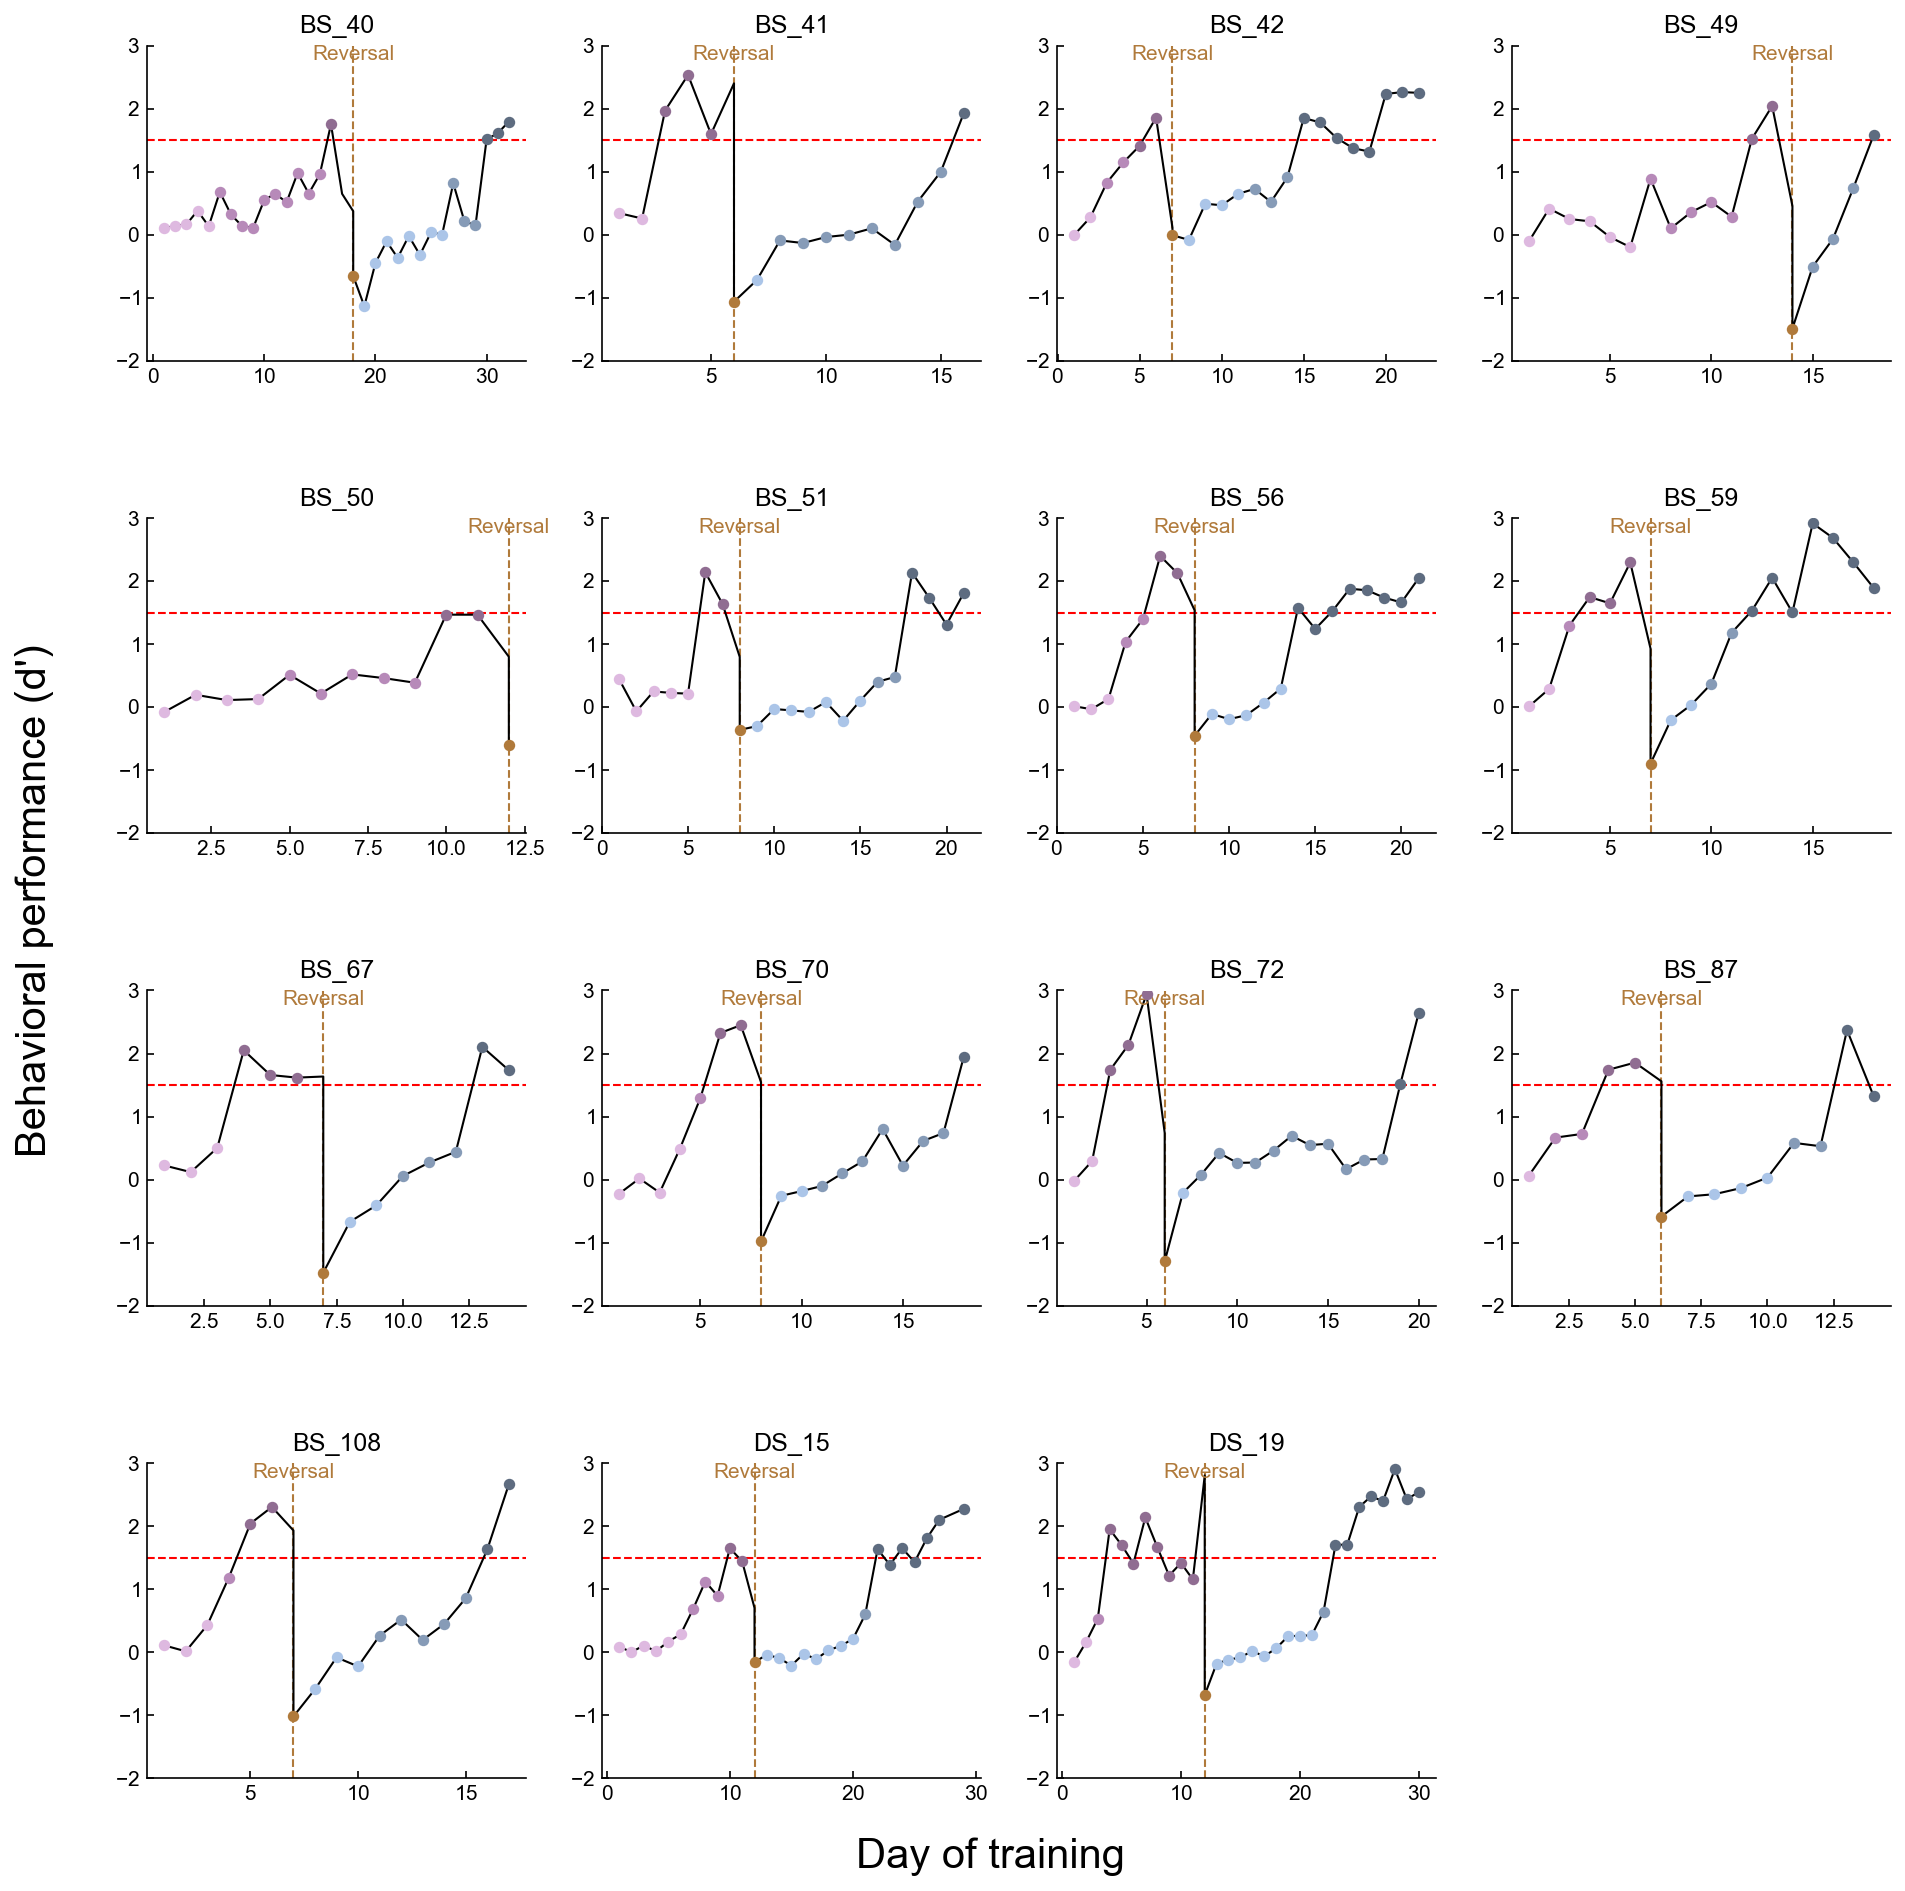

In [5]:
learning_phases,_,_ = ilep.calculateLearningPhasesV2(animals,animalBehaviors,plot=True)
#plt.savefig(os.path.join('D:\\\\TempFigures','All ephys animals learning phases.pdf'),transparent=False,facecolor="white")

In [6]:
EnumSession = []
EnumClust = []
sessions = os.listdir(act_directory)
for session in tqdm(sessions):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if sessionfile.meta.task in ['passive no behavior']:
        continue
    if sessionfile.meta.task in ['tuning nonreversal','tuning switch','tuning reversal']:
        continue
    if sessionfile.meta.region != 'AC':
        continue
        
    if sessionfile.meta.animal not in animals:
        continue
    
    if sessionfile.meta.animal == 'BS_59':
        print('A')
    
#     EnumSession.append(session)
    for clust in sessionfile.clusters.good:
        EnumSession.append(session)
        EnumClust.append(clust)

100%|██████████| 740/740 [00:33<00:00, 22.05it/s]


In [7]:
EILphases = np.full_like(EnumSession,np.nan)
error_animals = []

for idx,session in enumerate(tqdm(EnumSession)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        animal = sessionfile.meta.animal
        day = sessionfile.meta.day_of_training
        
        if sessionfile.meta.task in ['switch','opto switch','tuning switch']:
            EILphases[idx] = 'switch'

        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_early_days:
            EILphases[idx] = 'pre early'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal']  and day in learning_phases[animal].pre_late_days:
            EILphases[idx] = 'pre late'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_expert_days:
            EILphases[idx] = 'pre expert'

        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_early_days:
            EILphases[idx] = 'post early'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_late_days:
            EILphases[idx] = 'post late'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_expert_days:
            EILphases[idx] = 'post expert'
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        pass
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

100%|██████████| 1829/1829 [01:35<00:00, 19.20it/s]

errors for: []


# Load Decoding Data

In [8]:
stim_25s_df = pd.read_csv(stim25sdecodingfilename)
passive_df = pd.read_csv(passivedecodingfilename)
dec_df = pd.concat([stim_25s_df,passive_df])

def getDataPoint(df,session,clust,categories,column):
    df = df[df['session']==session]
    df = df[df['clust']==clust]
    df = df[df['categories']==categories]
    val = list(df[column])
    if len(val) == 1:
        return val[0]
    elif len(val) <= 0:
        return np.nan
    else:
        raise Exception('Incorrent length. Duplicate values')

In [9]:
stim_acc = []
choice_acc = []
stim_acc_c = []
choice_acc_c = []
stim_acc_s = []
choice_acc_s = []
pval_stim_s = []
pval_choice_s = []
pval_stim_c = []
pval_choice_c = []

for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    stim_accuracy = getDataPoint(dec_df,session,clust,'stimulus','weighted_accuracy')
    choice_accuracy = getDataPoint(dec_df,session,clust,'response','weighted_accuracy')
    
    pvalue_stim_s = getDataPoint(dec_df,session,clust,'stimulus','pval_synthetic_control')
    pvalue_choice_s = getDataPoint(dec_df,session,clust,'response','pval_synthetic_control')
    
    pvalue_stim_c = 0.01#getDataPoint(dec_df,session,clust,'stimulus','pval_shuffled_control')
    pvalue_choice_c = 0.01#getDataPoint(dec_df,session,clust,'response','pval_shuffled_control')
    
    stim_acc.append(stim_accuracy)
    choice_acc.append(choice_accuracy)
    
    pval_stim_s.append(pvalue_stim_s)
    pval_choice_s.append(pvalue_choice_s)
    
    pval_stim_c.append(pvalue_stim_c)
    pval_choice_c.append(pvalue_choice_c)
    
stim_acc = np.array(stim_acc)
choice_acc = np.array(choice_acc)
pval_stim_s = np.array(pval_stim_s)
pval_choice_s = np.array(pval_choice_s)
pval_stim_c = np.array(pval_stim_c)
pval_choice_c = np.array(pval_choice_c)

1829it [00:13, 136.35it/s]


In [10]:
def get_TE_mask(acc,pval_s):#,pval_c):
    low_decoders = np.less(acc,0.5)
    low_accuracies = acc[low_decoders]
    low_magnitudes = np.absolute(low_accuracies-0.5)

    low_magnitudes = np.sort(low_magnitudes)
    task_encoder_threshold = 0.5+low_magnitudes[int(0.95 * len(low_magnitudes))]
    print('Task encoder threshold: '+str(task_encoder_threshold))

    is_finite = np.isfinite(acc)
    #is_valid_pval = np.logical_and(np.less(pval_s,0.05) , np.less(pval_c,0.05))
    is_valid_pval = np.less(pval_s,0.05)
    is_TE = np.greater_equal(acc,task_encoder_threshold)
    is_TE = np.logical_and(is_TE,is_finite)
    is_TE = np.logical_and(is_TE,is_valid_pval)
    return is_TE,task_encoder_threshold

is_TE_s,task_encoder_threshold_s = get_TE_mask(stim_acc,pval_stim_s)#,pval_stim_c)
# is_TE_c,task_encoder_threshold_c = get_TE_mask(choice_acc,pval_choice_s)#,pval_choice_c)

Task encoder threshold: 0.55951845


# Passive Data

In [11]:
animals_in_cache = []

EnumACSession = []
EnumACClust = []

for session in tqdm(os.listdir(act_directory)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if session in ['TH_203_1_passive_AC.pickle','TH_203_4_passive_AC.pickle','TH_203_7_passive_AC.pickle','LA_204_2_passive_AC.pickle','LA_204_3_passive_AC.pickle','LA_204_4_passive_AC.pickle']:#Outlier sessions
            continue
            
    if sessionfile.meta.animal not in ['TH_201','TH_203','LA_204','LA_205','TH_200', 'TH_230','AE_229','TH_233','TH_234','AE_294']:
        continue
#     if sessionfile.meta.animal not in ['AE_294']:
#         continue
    
    animals_in_cache.append(sessionfile.meta.animal)
    
    for clust in sessionfile.clusters.good:
        if sessionfile.meta.region == "AC":
            EnumACSession.append(session)
            EnumACClust.append(clust)
        
animals_in_cache = np.unique(animals_in_cache)

100%|██████████| 740/740 [00:29<00:00, 24.75it/s]


In [12]:
#Define 6 learning phases(days)
pre_early = 4
pre_late = 6
pre_expert = 8
post_early = 12
post_late = 15
post_expert = 16

In [13]:
passive_stim_acc = []
passive_choice_acc = []
passive_stim_acc_c = []
passive_choice_acc_c = []
passive_stim_acc_s = []
passive_choice_acc_s = []
passive_pval_stim_s = []
passive_pval_choice_s = []
passive_pval_stim_c = []
passive_pval_choice_c = []

for idx,(session,clust) in tqdm(enumerate(zip(EnumACSession,EnumACClust))):
    passive_stim_accuracy = getDataPoint(dec_df,session,clust,'stimulus','weighted_accuracy')
    passive_choice_accuracy = getDataPoint(dec_df,session,clust,'response','weighted_accuracy')
    
    passive_pvalue_stim_s = getDataPoint(dec_df,session,clust,'stimulus','pval_synthetic_control')
    passive_pvalue_choice_s = getDataPoint(dec_df,session,clust,'response','pval_synthetic_control')
    
    passive_pvalue_stim_c = 0.01#getDataPoint(dec_df,session,clust,'stimulus','pval_shuffled_control')
    passive_pvalue_choice_c = 0.01#getDataPoint(dec_df,session,clust,'response','pval_shuffled_control')
    
    passive_stim_acc.append(passive_stim_accuracy)
    passive_choice_acc.append(passive_choice_accuracy)
    
    passive_pval_stim_s.append(passive_pvalue_stim_s)
    passive_pval_choice_s.append(passive_pvalue_choice_s)
    
    passive_pval_stim_c.append(passive_pvalue_stim_c)
    passive_pval_choice_c.append(passive_pvalue_choice_c)
    
passive_stim_acc = np.array(passive_stim_acc)
passive_choice_acc = np.array(passive_choice_acc)
passive_pval_stim_s = np.array(passive_pval_stim_s)
passive_pval_choice_s = np.array(passive_pval_choice_s)
passive_pval_stim_c = np.array(passive_pval_stim_c)
passive_pval_choice_c = np.array(passive_pval_choice_c)

is_TE_p,task_encoder_threshold_p = get_TE_mask(passive_stim_acc,passive_pval_stim_s)#,pval_stim_c)

1540it [00:08, 173.58it/s]

Task encoder threshold: 0.5634469617203128


In [14]:
cellstouseFR = 'all cells'
# cellstouseFR = 'task encoders'

animals_list = []
sessions_list = []
cluster_ID_list = []
phase_list = []
condition_list = []
FRmod_list = []

for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    #Currently not active as tuning curve animals have not been decoded
    if cellstouseFR == 'task encoders':
        if not np.isfinite(stim_acc[idx]) or pval_stim_s[idx] > 0.05 or stim_acc[idx] < task_encoder_threshold_s:
            continue
        if np.isnan(stim_acc[idx]) or np.isnan(pval_stim_s[idx]):
            continue
    
    if EILphases[idx] not in ['pre early','pre late','pre expert','post early','post late','post expert']:
        continue

    if EILphases[idx] not in ['pre expert','post expert'] and sessionfile.meta.animal in ['DS_15','DS_19']:
        continue
        
    try:
        FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
    except Exception as e:
        FRmod = np.nan
        print(e)

    animals_list.append(sessionfile.meta.animal)
    sessions_list.append(session)
    cluster_ID_list.append(clust)
    phase_list.append(EILphases[idx])
    condition_list.append('behaving')
    FRmod_list.append(FRmod)



for idx,(session,clust) in tqdm(enumerate(zip(EnumACSession,EnumACClust))):
    
    if session in ['TH_203_1_passive_AC.pickle','TH_203_4_passive_AC.pickle','TH_203_7_passive_AC.pickle','LA_204_2_passive_AC.pickle','LA_204_3_passive_AC.pickle','LA_204_4_passive_AC.pickle']:#Outlier sessions
        continue
    ACsessionfile = ilep.loadSessionCached(act_directory,session)



    # acc = passive_stim_acc[idx]
    # pval = passive_pval_stim_s[idx]
    # if acc < task_encoder_threshold_p or pval > 0.05:
    #     continue
    # if np.isnan(acc) or np.isnan(pval):
    #     continue


    
    try:
        FRmod = ACsessionfile.responsiveness[clust]['all_trials'].FRmodulation
    except Exception as e:
        print(e)
        FRmod = np.nan

    #1,2,3,4
    phase = 'N/A'
    if ACsessionfile.meta.day_of_training <= pre_early:
        phase = '1'
    #5,6
    if ACsessionfile.meta.day_of_training <= pre_late and ACsessionfile.meta.day_of_training >pre_early:
        phase = '2'
    #7,8
    if ACsessionfile.meta.day_of_training <= pre_expert and ACsessionfile.meta.day_of_training >pre_late:
        phase = '3'
    #9,10,11,12
    if ACsessionfile.meta.day_of_training <= post_early and ACsessionfile.meta.day_of_training >pre_expert:
        phase = '4'
    #13,14,15
    if ACsessionfile.meta.day_of_training <= post_late and ACsessionfile.meta.day_of_training >post_early:
        phase = '5'
    #16,17,18,19,20,21
    if ACsessionfile.meta.day_of_training >= post_expert:
        phase = '6'

    animals_list.append(ACsessionfile.meta.animal)
    sessions_list.append(session)
    cluster_ID_list.append(clust)
    phase_list.append(phase)
    condition_list.append('passive')
    FRmod_list.append(FRmod)

1829it [01:16, 24.00it/s]
1540it [00:33, 45.58it/s] 


In [15]:
df_dict = dict()
df_dict['animal'] = animals_list
df_dict['session'] = sessions_list
df_dict['cluster ID'] = cluster_ID_list
df_dict['phase'] = phase_list
df_dict['condition'] = condition_list
df_dict['FR modulation'] = FRmod_list
df = pd.DataFrame(df_dict)

In [16]:
df

,animal,session,cluster ID,phase,condition,FR modulation
0,BS_108,BS_108_1_AC.pickle,2,pre expert,behaving,9.972452
1,BS_108,BS_108_1_AC.pickle,8,pre expert,behaving,21.774194
2,BS_108,BS_108_1_AC.pickle,9,pre expert,behaving,15.806452
3,BS_108,BS_108_1_AC.pickle,14,pre expert,behaving,10.964187
4,BS_108,BS_108_1_AC.pickle,34,pre expert,behaving,16.989247
...,...,...,...,...,...,...
2898,TH_234,TH_234_4_passive_AC.pickle,63,3,passive,1.643192
2899,TH_234,TH_234_4_passive_AC.pickle,73,3,passive,25.644891
2900,TH_234,TH_234_4_passive_AC.pickle,91,3,passive,3.015075
2901,TH_234,TH_234_4_passive_AC.pickle,97,3,passive,13.065327


In [32]:
df.to_csv('..\\..\\Source Data Files\EDF 5e.csv')

In [33]:
np.sum(np.isfinite(df['FR modulation']))

2867

In [34]:
np.unique(df['animal'])

array(['AE_229', 'AE_294', 'BS_108', 'BS_40', 'BS_41', 'BS_42', 'BS_49',
       'BS_50', 'BS_51', 'BS_56', 'BS_67', 'BS_70', 'BS_72', 'BS_87',
       'DS_15', 'DS_19', 'LA_204', 'LA_205', 'TH_200', 'TH_201', 'TH_203',
       'TH_230', 'TH_233', 'TH_234'], dtype=object)

In [17]:
FRmod_preearly = []
FRmod_prelate = []
FRmod_preexpert = []
FRmod_postearly = []
FRmod_postlate = []
FRmod_postexpert = []

for row in df.iloc:
    if row['condition'] != 'behaving':
        continue
    
    if row['phase'] == 'pre early':
        FRmod_preearly.append(row['FR modulation'])
    if row['phase'] == 'pre late':
        FRmod_prelate.append(row['FR modulation'])
    if row['phase'] == 'pre expert':
        FRmod_preexpert.append(row['FR modulation'])
        
    if row['phase'] == 'post early':
        FRmod_postearly.append(row['FR modulation'])
    if row['phase'] == 'post late':
        FRmod_postlate.append(row['FR modulation'])
    if row['phase'] == 'post expert':
        FRmod_postexpert.append(row['FR modulation'])

FRmod_preearly = np.array(FRmod_preearly)
FRmod_prelate = np.array(FRmod_prelate)
FRmod_preexpert = np.array(FRmod_preexpert)
FRmod_postearly = np.array(FRmod_postearly)
FRmod_postlate = np.array(FRmod_postlate)
FRmod_postexpert = np.array(FRmod_postexpert)

In [18]:
FRmod_passive_preearly = []
FRmod_passive_prelate = []
FRmod_passive_preexpert = []
FRmod_passive_postearly = []
FRmod_passive_postlate = []
FRmod_passive_postexpert = []

for row in df.iloc:
    if row['condition'] != 'passive':
        continue
    
    if row['phase'] == '1':
        FRmod_passive_preearly.append(row['FR modulation'])
    if row['phase'] == '2':
        FRmod_passive_prelate.append(row['FR modulation'])
    if row['phase'] == '3':
        FRmod_passive_preexpert.append(row['FR modulation'])
        
    if row['phase'] == '4':
        FRmod_passive_postearly.append(row['FR modulation'])
    if row['phase'] == '5':
        FRmod_passive_postlate.append(row['FR modulation'])
    if row['phase'] == '6':
        FRmod_passive_postexpert.append(row['FR modulation'])

FRmod_passive_preearly = np.array(FRmod_passive_preearly)
FRmod_passive_prelate = np.array(FRmod_passive_prelate)
FRmod_passive_preexpert = np.array(FRmod_passive_preexpert)
FRmod_passive_postearly = np.array(FRmod_passive_postearly)
FRmod_passive_postlate = np.array(FRmod_passive_postlate)
FRmod_passive_postexpert = np.array(FRmod_passive_postexpert)

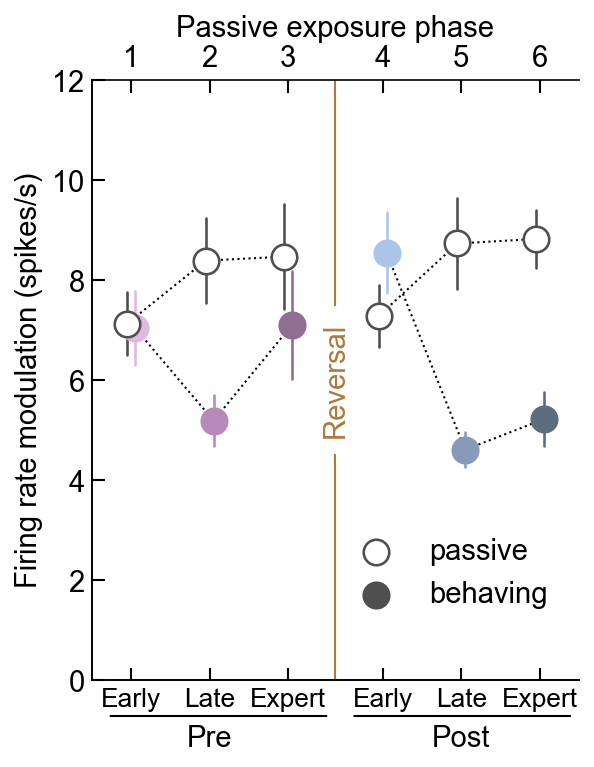

In [38]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.1
offset_distance = 0.05

################################################################################################################

data = [FRmod_preearly,FRmod_prelate,FRmod_preexpert,FRmod_postearly,FRmod_postlate,FRmod_postexpert]
data = [ilep.rmnan(d) for d in data]
#Plot summary
colmaxes = [np.nan]*6
for idx,(column,polarity) in enumerate(zip(data,[-1,-1,-1,1,1,1])):
    eye_color = PHASE_COLORS[idx]
    border_color=eye_color
    summary_size=150
    summary_width=1.25
    
    #Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    median = np.mean(column)
    Q1 = median - sem(column)
    Q3 = median + sem(column)
    colmaxes[idx] = Q3
    
    ax.scatter([idx+offset_distance+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+offset_distance+polarity*switch_offset, idx+offset_distance+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
medians = [np.mean(col) for col in data]
plt.plot(np.linspace(0,2,3)+offset_distance-switch_offset,medians[0:3],color='k',linestyle=':',lw=1)
plt.plot(np.linspace(3,5,3)+offset_distance+switch_offset,medians[3:6],color='k',linestyle=':',lw=1)
    
########################################################
passive_data = [FRmod_passive_preearly,FRmod_passive_prelate,FRmod_passive_preexpert,FRmod_passive_postearly,FRmod_passive_postlate,FRmod_passive_postexpert]
passive_data = [ilep.rmnan(d) for d in passive_data]

#Plot summary
passive_colmaxes = [np.nan]*6
for idx,(column,polarity) in enumerate(zip(passive_data,[-1,-1,-1,1,1,1])):
    border_color=PASSIVE_COLOR
    eye_color='white'

    summary_size=150
    summary_width=1.25
    
    #Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    median = np.mean(column)
    Q1 = median - sem(column)
    Q3 = median + sem(column)
    passive_colmaxes[idx] = Q3
    
    ax.scatter([idx-offset_distance+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10,marker='o')
    ax.plot([idx-offset_distance+polarity*switch_offset, idx-offset_distance+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
medians = [np.mean(col) for col in passive_data]
plt.plot(np.linspace(0,2,3)-offset_distance-switch_offset,medians[0:3],color='k',linestyle=':',lw=1)
plt.plot(np.linspace(3,5,3)-offset_distance+switch_offset,medians[3:6],color='k',linestyle=':',lw=1)

################################################################################################################

labels = ['Early','Late','Expert','Early','Late','Expert']
labels2 = [1,2,3,4,5,6]

ax.set_ylim([0,12])
#ax.set_yticks([4,5,6,7,8,9,10,11])
#ax.set_yticklabels([4,5,6,7,8,9,10,11])
ylab = ax.set_ylabel('Firing rate modulation (spikes/s)')
              
ax.set_xlim([-0.5-switch_offset,5.5+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)

ax2 = ax.twiny()
ax2.spines['top'].set_visible(True)
ax2.get_xaxis().set_visible(True)
ax2.set_xlim([-0.5-switch_offset,5.5+switch_offset])
ax2.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax2.set_xticklabels(labels2)
xlab2 = ax2.set_xlabel('Passive exposure phase')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)
ax2.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass
for item in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label] +
    ax2.get_xticklabels() + ax2.get_yticklabels()):
    item.set_fontsize(stdfont)

ax.scatter([], [], ec=PASSIVE_COLOR,fc='white', s=summary_size,lw=summary_width,marker='o',label='passive')
ax.scatter([], [], ec=PASSIVE_COLOR,fc=PASSIVE_COLOR, s=summary_size,lw=summary_width,marker='o',label='behaving')
ax.legend(frameon=False,loc=(0.5,0.1),fontsize=14)
    
### Log
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

### Linear
Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2,xlab2]
# fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','AC Mean of FRmodulation over learning V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [39]:
data_dec = SimpleNamespace()
data_dec.preearly = np.abs(FRmod_preearly)
data_dec.prelate = np.abs(FRmod_prelate)
data_dec.preexpert = np.abs(FRmod_preexpert)
data_dec.postearly = np.abs(FRmod_postearly)
data_dec.postlate = np.abs(FRmod_postlate)
data_dec.postexpert = np.abs(FRmod_postexpert)

data_dec2 = SimpleNamespace()
data_dec2.preearly = np.abs(FRmod_passive_preearly)
data_dec2.prelate = np.abs(FRmod_passive_prelate)
data_dec2.preexpert = np.abs(FRmod_passive_preexpert)
data_dec2.postearly = np.abs(FRmod_passive_postearly)
data_dec2.postlate = np.abs(FRmod_passive_postlate)
data_dec2.postexpert = np.abs(FRmod_passive_postexpert)
ilep.nonparametricIndependentStatsCompareToOther(data_dec,data_dec2)
pass

            Source             SS      DF           MS          F     p-unc  \
0            phase     933.937019     5.0   186.787404   1.514212  0.181894   
1          context    2727.456782     1.0  2727.456782  22.110419  0.000003   
2  phase * context    2917.501650     5.0   583.500330   4.730208  0.000263   
3         Residual  352181.883863  2855.0   123.356176        NaN       NaN   

        np2  
0  0.002645  
1  0.007685  
2  0.008216  
3       NaN  

          phase  A  B         p-unc        p-corr    hedges
16   post-early  A  B  8.557888e-01  8.557888e-01  0.102383
17  post-expert  A  B  4.477813e-06  1.343344e-05 -0.323668
18    post-late  A  B  2.238025e-08  1.342815e-07 -0.443803
19    pre-early  A  B  8.428451e-01  8.557888e-01 -0.009740
20   pre-expert  A  B  3.125624e-01  4.688436e-01 -0.098258
21     pre-late  A  B  2.173601e-02  4.347201e-02 -0.290424
key preearly has 148 and 198 non-nan elements
key prelate has 187 and 241 non-nan elements
key preexpert has 97 a

In [19]:
df_beh = df[df['condition']=='behaving']
beh_animals = np.unique(df_beh['animal'])

FR_preearly = []
FR_prelate = []
FR_preexpert = []
FR_postearly = []
FR_postlate = []
FR_postexpert = []
for animal in beh_animals:
    preearly_animal = []
    prelate_animal = []
    preexpert_animal = []
    postearly_animal = []
    postlate_animal = []
    postexpert_animal = []
    for row in df_beh.iloc():
        if row['animal'] != animal:
            continue
        if row['phase'] == 'pre early':
            preearly_animal.append(row['FR modulation'])
        if row['phase'] == 'pre late':
            prelate_animal.append(row['FR modulation'])
        if row['phase'] == 'pre expert':
            preexpert_animal.append(row['FR modulation'])
        if row['phase'] == 'post early':
            postearly_animal.append(row['FR modulation'])
        if row['phase'] == 'post late':
            postlate_animal.append(row['FR modulation'])
        if row['phase'] == 'post expert':
            postexpert_animal.append(row['FR modulation'])
    preearly_animal = np.array(preearly_animal)
    prelate_animal = np.array(prelate_animal)
    preexpert_animal = np.array(preexpert_animal)
    postearly_animal = np.array(postearly_animal)
    postlate_animal = np.array(postlate_animal)
    postexpert_animal = np.array(postexpert_animal)
    
    FR_preearly.append(preearly_animal)
    FR_prelate.append(prelate_animal)
    FR_preexpert.append(preexpert_animal)
    FR_postearly.append(postearly_animal)
    FR_postlate.append(postlate_animal)
    FR_postexpert.append(postexpert_animal)



df_passive = df[df['condition']=='passive']
passive_animals = np.unique(df_passive['animal'])

passive_FR_preearly = []
passive_FR_prelate = []
passive_FR_preexpert = []
passive_FR_postearly = []
passive_FR_postlate = []
passive_FR_postexpert = []
for animal in passive_animals:
    preearly_animal = []
    prelate_animal = []
    preexpert_animal = []
    postearly_animal = []
    postlate_animal = []
    postexpert_animal = []
    for row in df_passive.iloc():
        if row['animal'] != animal:
            continue
        if row['phase'] == '1':
            preearly_animal.append(row['FR modulation'])
        if row['phase'] == '2':
            prelate_animal.append(row['FR modulation'])
        if row['phase'] == '3':
            preexpert_animal.append(row['FR modulation'])
        if row['phase'] == '4':
            postearly_animal.append(row['FR modulation'])
        if row['phase'] == '5':
            postlate_animal.append(row['FR modulation'])
        if row['phase'] == '6':
            postexpert_animal.append(row['FR modulation'])
    preearly_animal = np.array(preearly_animal)
    prelate_animal = np.array(prelate_animal)
    preexpert_animal = np.array(preexpert_animal)
    postearly_animal = np.array(postearly_animal)
    postlate_animal = np.array(postlate_animal)
    postexpert_animal = np.array(postexpert_animal)
    
    passive_FR_preearly.append(preearly_animal)
    passive_FR_prelate.append(prelate_animal)
    passive_FR_preexpert.append(preexpert_animal)
    passive_FR_postearly.append(postearly_animal)
    passive_FR_postlate.append(postlate_animal)
    passive_FR_postexpert.append(postexpert_animal)


In [20]:
mean_pc_NCR = []
sem_pc_NCR = []
for FRmods in [FR_preearly,FR_prelate,FR_preexpert,FR_postearly,FR_postlate,FR_postexpert]:
    Mw,SEMw = ilep.bootstrap_Mw_SEMw(FRmods,n_frac=1,CR_NCR_thresh=3.5)
    mean_pc_NCR.append(Mw)
    sem_pc_NCR.append(SEMw)

In [21]:
passive_mean_pc_NCR = []
passive_sem_pc_NCR = []
for FRmods in [passive_FR_preearly,passive_FR_prelate,passive_FR_preexpert,passive_FR_postearly,passive_FR_postlate,passive_FR_postexpert]:
    Mw,SEMw = ilep.bootstrap_Mw_SEMw(FRmods,n_frac=1,CR_NCR_thresh=3.5)
    passive_mean_pc_NCR.append(Mw)
    passive_sem_pc_NCR.append(SEMw)

In [22]:
print('loaded')

loaded


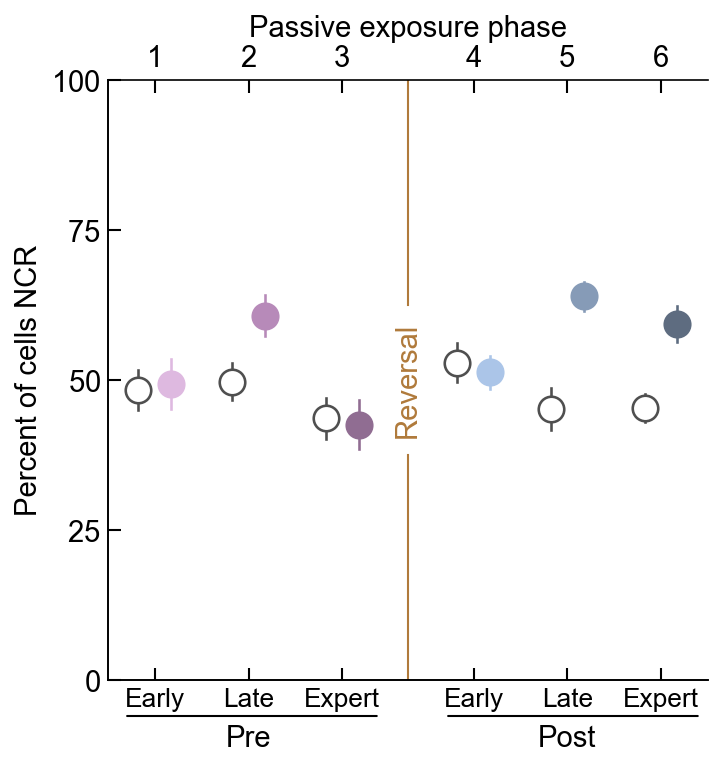

In [23]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

def statsbar(ax,barheight,xpoints,stemheights,text=None,lw=1):
    ymax = ax.get_ylim()[1]
    ymin = ax.get_ylim()[0]
    yrange = ymax-ymin
    ydist = 0.025*yrange
    
    ax.plot([xpoints[0]]*2,[stemheights[0]+ydist,barheight],lw=lw,color='k')
    ax.plot([xpoints[1]]*2,[stemheights[1]+ydist,barheight],lw=lw,color='k')
    ax.plot(xpoints,[barheight]*2,lw=lw,color='k')
    
    if not text is None:
        ax.text(np.mean(xpoints),barheight + ydist,text,horizontalalignment='center',verticalalignment='center')

fig,ax = make_axis_size(4, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.2

################################################################################################################

wid = 0.175

for idx,p in zip(range(6),[-1,-1,-1,1,1,1]):
    ax.scatter([idx-wid+p*switch_offset],(passive_mean_pc_NCR[idx]),fc='white',ec=PASSIVE_COLOR,s=150,zorder=10,marker='o',lw=1.25)
    ax.plot([idx-wid+p*switch_offset,idx-wid+p*switch_offset],[(passive_mean_pc_NCR[idx]-passive_sem_pc_NCR[idx]),(passive_mean_pc_NCR[idx]+passive_sem_pc_NCR[idx])],color=PASSIVE_COLOR,lw=1.25,zorder=9)
    
    ax.scatter([idx+wid+p*switch_offset],(mean_pc_NCR[idx]),c=PHASE_COLORS[idx],s=150,zorder=10,marker='o',lw=1.25)
    ax.plot([idx+wid+p*switch_offset,idx+wid+p*switch_offset],[(mean_pc_NCR[idx]-sem_pc_NCR[idx]),(mean_pc_NCR[idx]+sem_pc_NCR[idx])],color=PHASE_COLORS[idx],lw=1.25,zorder=9)
    
#ax.scatter([0,1,2,3,4,5],(mean_pc_NCR_passive)/100,fc='white',ec=GOOD_GREY,s=50,zorder=9,marker='o',lw=1)
# statsbar(ax,82,[1-wid-switch_offset,1+wid-switch_offset],stemheights=[passive_mean_pc_NCR[1]+passive_sem_pc_NCR[1] , mean_pc_NCR[1]+sem_pc_NCR[1]],text='*',lw=1)
# statsbar(ax,82,[4-wid+switch_offset,4+wid+switch_offset],stemheights=[passive_mean_pc_NCR[4]+passive_sem_pc_NCR[4] , mean_pc_NCR[4]+sem_pc_NCR[4]],text='****',lw=1)
# statsbar(ax,70,[5-wid+switch_offset,5+wid+switch_offset],stemheights=[passive_mean_pc_NCR[5]+passive_sem_pc_NCR[5] , mean_pc_NCR[5]+sem_pc_NCR[5]],text='****',lw=1)

################################################################################################################

labels = ['Early','Late','Expert','Early','Late','Expert']
labels2 = [1,2,3,4,5,6]

ylab = ax.set_ylabel('Percent of cells NCR')
ax.set_ylim([0,100])
ax.set_yticks([0,25,50,75,100])
              
ax.set_xlim([-0.5-switch_offset,5.5+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)

ax2 = ax.twiny()
ax2.spines['top'].set_visible(True)
ax2.get_xaxis().set_visible(True)
ax2.set_xlim([-0.5-switch_offset,5.5+switch_offset])
ax2.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax2.set_xticklabels(labels2)
xlab2 = ax2.set_xlabel('Passive exposure phase')
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.025, -stdyfrac), xycoords='axes fraction', xytext=(0.455, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.56, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)
ax2.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass
for item in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label] +
    ax2.get_xticklabels() + ax2.get_yticklabels()):
    item.set_fontsize(stdfont)

# ax.scatter([], [], ec=PASSIVE_COLOR,fc='white', s=50,lw=1,marker='o',label='passive')
# ax.scatter([], [], ec=PASSIVE_COLOR,fc=PASSIVE_COLOR, s=50,lw=1,marker='o',label='behaving')
# ax.legend(frameon=False,loc=(0.5,0.1),fontsize=14)

### Log
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

### Linear
Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
# fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','AC percent NCR V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [ ]:
# Regenerated stats. Non-deterministic

In [24]:
Xs = [FR_preearly,FR_prelate,FR_preexpert,FR_postearly,FR_postlate,FR_postexpert]
Ys = [passive_FR_preearly,passive_FR_prelate,passive_FR_preexpert,passive_FR_postearly,passive_FR_postlate,passive_FR_postexpert]

pvals = [np.nan]*6
for idx,(X,Y) in enumerate(zip(Xs,Ys)):
    pvals[idx] = ilep.bootstrap_pc_NCR_test(X,Y,B=250000,CR_NCR_thresh=[3.5])
    print(pvals[idx])
    
_,pvals_corr = pg.multicomp(pvals,method='fdr_bh')
print()
print(pvals_corr)

0.882976
0.02003200000000005
0.85748
0.7075359999999999
1.6000000000016e-05
0.000256000000000034

[8.82976e-01 4.00640e-02 8.82976e-01 8.82976e-01 9.60000e-05 7.68000e-04]
